# Data Cleaning

In this part we conduct data preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
dataset_path = "../dataset/"
data = pd.read_csv(dataset_path + "data_joined.csv")
data=data.drop('Filming_Location',axis=1)
a=data
a.reset_index(drop=True,inplace=True)
a.head(1)

,Movie_Title,Movie_ID,Budget,Cast,Crew,Studios,Genre,Keywords,Languages,Countries,Release_Data,Runtime,Gross_worldwide,Rating,Rating_Count,ListOfCertificate
0,Star Wars: Episode VII - The Force Awakens,2488496,"$245,000,000","Daisy Ridley,John Boyega,Oscar Isaac,Domhnall ...","Lawrence Kasdan,Michael Arndt,J.J. Abrams","Lucasfilm,Bad Robot,Truenorth Productions","Action,Adventure,Sci-Fi","reboot,sanitation employee,remake,crash landin...",English,United States,2015-12-18,2 hours 18 minutes,"$2,069,521,700",7.8,893K,PG-13


In [3]:
listToDrop=list(a[a['Gross_worldwide'].isna()].index)
a=a.drop(listToDrop)
a['Budget']=a['Budget'].fillna("$0")

In [4]:
a.isnull().sum()

Movie_Title            0
Movie_ID               0
Budget                 0
Cast                   5
Crew                   4
Studios               41
Genre                974
Keywords              18
Languages              6
Countries              5
Release_Data           0
Runtime                4
Gross_worldwide        0
Rating                 1
Rating_Count           1
ListOfCertificate    643
dtype: int64

In [5]:
a['Runtime']=a['Runtime'].fillna("0")
a['Rating']=a['Rating'].fillna(5.0)
a['Rating_Count']=a['Rating_Count'].fillna("0K")
a['ListOfCertificate']=a['ListOfCertificate'].fillna("G")
a=a.fillna("")

In [6]:
a=a.reset_index(drop=True)

## Currency attribute

**Input**: Input dataframe with unprocessed currency

**Output**: Processed one

Currency type in Budget and Gross_Woldwide

In [7]:
currency=[str(s)[0] for s in a['Budget'].unique()]
print(set(currency))
currency=[str(s)[0] for s in a['Gross_worldwide'].unique()]
print(set(currency))

{'€', '$'}
{'$'}


Function use to parse money

In [8]:
def parseMoney(beforeParsed):
    #Loại bỏ ký tự '$','€' và ',' trong xâu rồi chuyển về dạng integer
    if '$' in beforeParsed:
      afterParsed=int(beforeParsed.strip('$').replace(',',""))
    else:
      afterParsed=int(int(beforeParsed.strip('€').replace(',',""))*1.14)
    return afterParsed

Convert currency

In [9]:
a['Budget']=a['Budget'].apply(parseMoney)
a['Gross_worldwide']=a['Gross_worldwide'].apply(parseMoney)

In [10]:
a.head(1)

,Movie_Title,Movie_ID,Budget,Cast,Crew,Studios,Genre,Keywords,Languages,Countries,Release_Data,Runtime,Gross_worldwide,Rating,Rating_Count,ListOfCertificate
0,Star Wars: Episode VII - The Force Awakens,2488496,245000000,"Daisy Ridley,John Boyega,Oscar Isaac,Domhnall ...","Lawrence Kasdan,Michael Arndt,J.J. Abrams","Lucasfilm,Bad Robot,Truenorth Productions","Action,Adventure,Sci-Fi","reboot,sanitation employee,remake,crash landin...",English,United States,2015-12-18,2 hours 18 minutes,2069521700,7.8,893K,PG-13


## Multivalued attributes

Multivalued attributes is seperated by comma (,)

- The fields Cast, Genre, Studios, ListOfCertificate, Keywords, Languages, Countries are multivalued so we change to **List** Data Structure

In [11]:
def convertToList(fieldValue):
  arrayValue=fieldValue.split(',')
  if '' in arrayValue:
    return []
  return arrayValue

In [12]:
# Cast, Genre, Studios, ListOfCertificate
cols =['Cast', 'Genre', 'Studios', 'ListOfCertificate','Keywords', 'Languages', 'Countries','Crew']
for col in cols:
  a[col]=a[col].apply(convertToList)

Note!
After change to list we will need this function this to load again in another part

In [13]:
"""

import ast
cols =['Cast', 'Genre', 'Studios', 'ListOfCertificate','Keywords', 'Languages', 'Countries']
for col in cols:
    a[col]=a[col].apply(ast.literal_eval)
    
"""

"\n\nimport ast\ncols =['Cast', 'Genre', 'Studios', 'ListOfCertificate','Keywords', 'Languages', 'Countries']\nfor col in cols:\n    a[col]=a[col].apply(ast.literal_eval)\n    \n"

- The fields ListOfCertificate are multivalued and also need to clean

In [14]:
def getUniqueCer(dataframe):   
    lCer=set()
    for i in dataframe['ListOfCertificate']:
        for y in i:
            lCer.add(y)
    return lCer

In [15]:
getUniqueCer(a)

{'G', 'GP', 'M', 'M/PG', 'NC-17', 'PG', 'PG-13', 'R', 'X'}

Those certificate is out of date. Can be replace:

- M, GP and M/PG are listed to PG

- X replaced by NC-17

In [16]:
def convertCertificate(certificates):
    newCertificate=set()
    type1=['M','GP','M/PG']
    type2=['X']
    for i in certificates:
        if i in type1:
            newCertificate.add('PG')
        elif i in type2:
            newCertificate.add('NC-17')
        else:
            newCertificate.add(i)
    return list(newCertificate)

In [17]:
a['ListOfCertificate']=a['ListOfCertificate'].apply(convertCertificate)
getUniqueCer(a)

{'G', 'NC-17', 'PG', 'PG-13', 'R'}

## Process multivalued fields with Money and Count
1. Input
- Dataframe: Dataframe need to be process
- Name: Name of the columns we want to process. In this project they are **Cast**, **Genre** or **Studios**

2. Output
- Output: DataFrame contains information related to the columns combined with Money and Count

In [18]:
def parseWithMoneyAndCount(dataframe, colName):
    result = []
    count = []
    gross = []
    for i,record in enumerate(dataframe[colName]):
      for x in record:
        #Lưu kết quả vào mảng tương ứng
          result.append(x)
          gross.append(dataframe['Gross_worldwide'][i])
          count.append(1)
    #Tạo dataFrame
    t = pd.DataFrame({colName:result, 'Money':gross, 'Count':count})
    #Loại bỏ các giá trị trùng nhau và cộng các hàng tương ứng lại 
    result = t.groupby(colName).sum()
    #Sắp xếp lại dataFrame
    sort_by_money = result.sort_values('Money', ascending = False)
    return sort_by_money

## Xử lý dữ liệu với cột Cast, Genre, Studios, ListOfCertificate

- Tách lấy thông tin cần thiết

- Tính tổng số doanh thu của những bộ phim mà họ từng tham gia

In [19]:
# phần Money trong hàm này cần được chuẩn hóa bằng hàm xử lý tiền tệ trước khi truyền vào
cast = parseWithMoneyAndCount(a,'Cast')
cast

,Money,Count
Cast,,
Samuel L. Jackson,18580682439,83
Robert Downey Jr.,15200028143,54
Scarlett Johansson,14407657895,44
Zoe Saldana,12294639242,29
Dwayne Johnson,11942043248,33
...,...,...
Jeff Prewett,95,1
Matthew R. Anderson,95,1
Kenny Taylor,95,1


Tương tự với cột Genre, Studios và ListOfCertificate

In [20]:
genre = parseWithMoneyAndCount(a,'Genre')
genre

,Money,Count
Genre,,
Adventure,298281440727,1515
Action,270712872044,1892
Drama,224422468047,4454
Comedy,222959609180,3232
Thriller,169670494650,2224
Fantasy,153116140508,981
Sci-Fi,152723454914,866
Family,137386773092,936
Romance,109277844855,2201


In [21]:
studio = parseWithMoneyAndCount(a,'Studios')
studio

,Money,Count
Studios,,
Walt Disney Pictures,69222893046,214
Warner Bros.,67324250819,486
Universal Pictures,65634910319,514
Paramount Pictures,55195232415,451
Columbia Pictures,53369131398,424
...,...,...
Paramount Famous Lasky Corporation,746,1
Walter Wanger Productions,623,1
Break Media,528,1


In [22]:
certificate = parseWithMoneyAndCount(a,'ListOfCertificate')
certificate

,Money,Count
ListOfCertificate,,
PG-13,283553468080,2466
R,170006305715,3867
PG,144055409565,1621
G,42824185750,937
NC-17,925845011,37


## Xử lý dữ liệu cột Keywords, Languages, Countries
Dữ liệu dạng này chủ yếu chỉ cần tách và xem xét đến độ phổ biến nên chỉ cần đếm số lượng

In [23]:
def parseWithCount(dataframe, name):
    result = []
    count = []
    for record in dataframe[name]:
      for x in record:
        result.append(x)
        count.append(1)
    result = pd.DataFrame({name:result, 'Count':count})
    #Loại bỏ trùng lặp 
    result = result.groupby(name).sum()
    sort_by_count = result.sort_values('Count', ascending=False)
    return sort_by_count

### Cột keywords

In [24]:
keywords = parseWithCount(a,'Keywords')
keywords

,Count
Keywords,
female nudity,194
sex scene,164
murder,158
female protagonist,157
f rated,146
...,...
highgate cemetary,1
highlander character,1
highlands,1


### Cột Languages

In [25]:
languages = parseWithCount(a, 'Languages')
languages

,Count
Languages,
English,8150
French,977
Spanish,946
German,466
Italian,432
...,...
Papiamento,1
Oriya,1
Ojibwa,1


### Cột Countries

In [26]:
countries = parseWithCount(a, 'Countries')
countries

,Count
Countries,
United States,7375
United Kingdom,1447
France,793
Canada,692
Germany,553
...,...
Liberia,1
Lithuania,1
Mauritania,1


## Chuẩn hóa lại dữ liệu dạng thời gian
### 1. Dữ liệu cột runtime dạng giờ-phút
Hàm chuyển thời gian về dạng phút

In [27]:
def convertTime(time):
    time = str(time)
    # Loại bỏ khoảng trắng
    time = time.replace(" ", "")
    # nếu trong chuỗi có chứa 'hour' -> có 2 khả năng là chuỗi có chứa 'hours' hoặc 'hour' 
    if "hour" in time:
        hours = 0
        # Nếu chuỗi chứa 'hours', loại bỏ 'hours' và lấy ký tự đầu tiên nhân với 60
        if "hours" in time:
            hours = int(time[0])*60
            after_eliminate_hour = time.replace("hours", "")
        else:
        # Nếu không thì nghĩa là ký tự đầu tiên bằng 1 => 60 phút
            hours = 60
            after_eliminate_hour = time.replace("hour", "")
        minutes = 0
        # Sau đó lấy số phút đó cộng với số phút nếu có đằng sau 
        if "minute" in after_eliminate_hour:
            if "minutes" in after_eliminate_hour:
                minutes = int(after_eliminate_hour.replace("minutes","")[1:])
            else:
                minutes = 1
        return int(hours)+int(minutes)
    # Nếu chuỗi không chứa 'hour' -> chỉ cần loại bỏ chuỗi 'minutes' rồi chuyển về int là xong
    else:
      return int(time.replace("minutes",""))

Chuẩn hóa thời gian cho bộ dữ liệu

In [28]:
a['Runtime']=a['Runtime'].apply(convertTime)

In [29]:
a['Runtime'].value_counts()

100    259
97     258
96     245
101    244
95     236
      ... 
64       1
288      1
207      1
60       1
194      1
Name: Runtime, Length: 160, dtype: int64

### 2. Dữ liệu cột release_date dạng ngày tháng năm
Tách ngày, tháng, năm của từng bộ phim

In [30]:
a['Release_Data']=pd.to_datetime(a['Release_Data'], format='%Y-%m-%d')
a['Release_Year']=a['Release_Data'].apply(lambda x: x.year)
a['Release_Month']=a['Release_Data'].apply(lambda x: x.month)
a['Release_Day']=a['Release_Data'].apply(lambda x: x.day)

## Xử lý dữ liệu cột Rating và Rating_Count
- Hàm chuẩn hóa lại dữ liệu cột Rating_Count và chuyển dữ liệu cột Rating về float

In [31]:
def convertRatingCount(rating_count):
  rate = str(rating_count)
  if 'M' in rate:
        return int(float(rate.replace("M", ""))*1000000)
  elif 'K' in rate:
        return int(float(rate.replace("K", ""))*1000)
  else:
        return int(rate)

In [32]:
# Đưa dữ liệu cột rating_count về integer
a['Rating_Count']=a['Rating_Count'].apply(convertRatingCount)
# Đưa dữ liệu cột rating về dạng float
a['Rating']=a['Rating'].astype(float)

## Xuất ra file CSV

In [33]:
cast.to_csv("../dataset/processed/Cast.csv", index = False)
genre.to_csv("../dataset/processed/Genre.csv", index = False)
studio.to_csv("../dataset/processed/Studio.csv", index = False)
keywords.to_csv("../dataset/processed/Keywords.csv", index = False)
languages.to_csv("../dataset/processed/Languages.csv", index = False)
countries.to_csv("../dataset/processed/Countries.csv", index = False)
a.to_csv("../dataset/processed/cleanedData.csv",index=False)

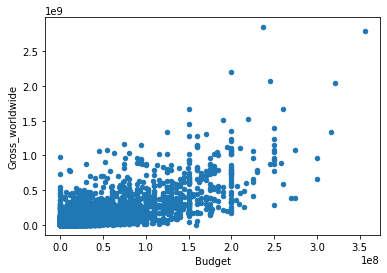

In [34]:
a.plot(kind="scatter", x ="Budget", y = "Gross_worldwide")
plt.show()